## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [ ]:
tqqq = yf.download('TQQQ', start="2019-01-01", end="2023-12-31")
tqqq

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,8.695000,9.557500,8.682500,9.392500,9.084021,135832800
2019-01-03,8.995000,9.102500,8.407500,8.482500,8.203909,165255200
2019-01-04,8.887500,9.690000,8.792500,9.567500,9.253274,136482000
2019-01-07,9.617500,10.037500,9.532500,9.872500,9.548259,106553200
2019-01-08,10.172500,10.277500,9.725000,10.157500,9.823897,105811200
...,...,...,...,...,...,...
2023-12-22,50.599998,50.939999,49.639999,50.349998,49.817402,66114200
2023-12-26,50.639999,51.509998,50.619999,51.270000,50.727673,43685600
2023-12-27,51.349998,51.660000,51.020000,51.540001,50.994816,55747800


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [ ]:
tqqq.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


결측값 없음

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [ ]:
tqqq = tqqq.sort_index()
tqqq

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,8.695000,9.557500,8.682500,9.392500,9.084021,135832800
2019-01-03,8.995000,9.102500,8.407500,8.482500,8.203909,165255200
2019-01-04,8.887500,9.690000,8.792500,9.567500,9.253274,136482000
2019-01-07,9.617500,10.037500,9.532500,9.872500,9.548259,106553200
2019-01-08,10.172500,10.277500,9.725000,10.157500,9.823897,105811200
...,...,...,...,...,...,...
2023-12-22,50.599998,50.939999,49.639999,50.349998,49.817402,66114200
2023-12-26,50.639999,51.509998,50.619999,51.270000,50.727673,43685600
2023-12-27,51.349998,51.660000,51.020000,51.540001,50.994816,55747800


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

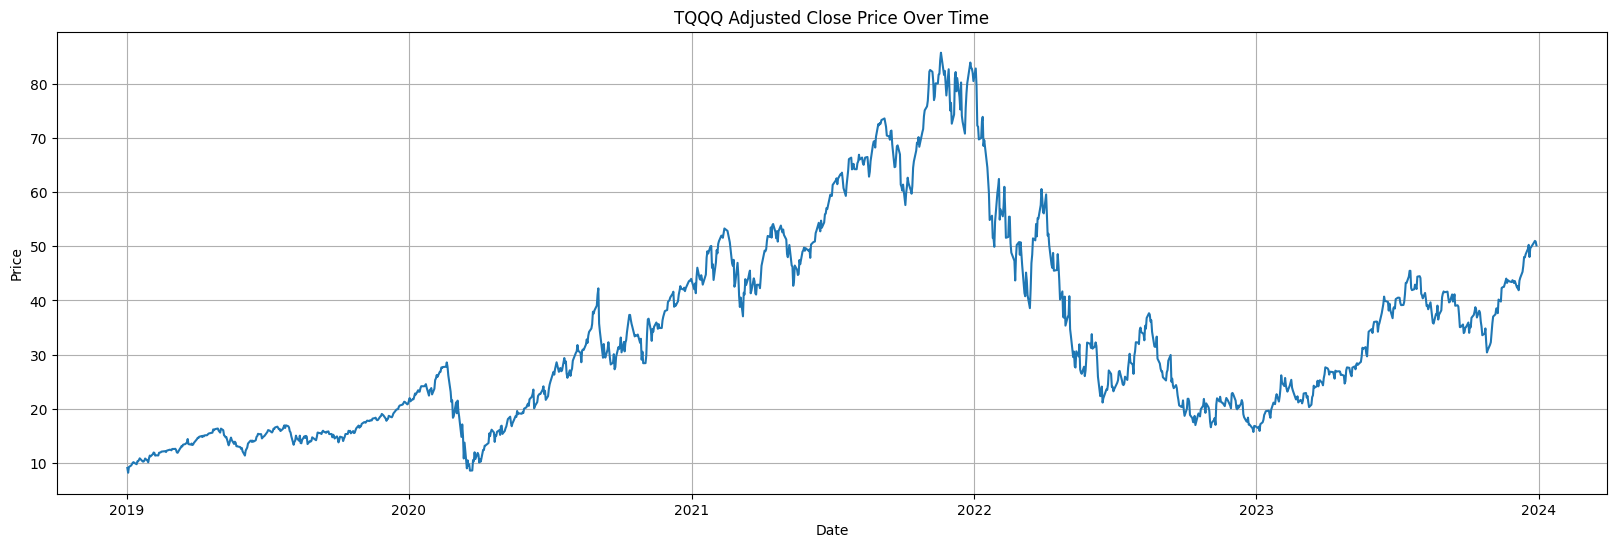

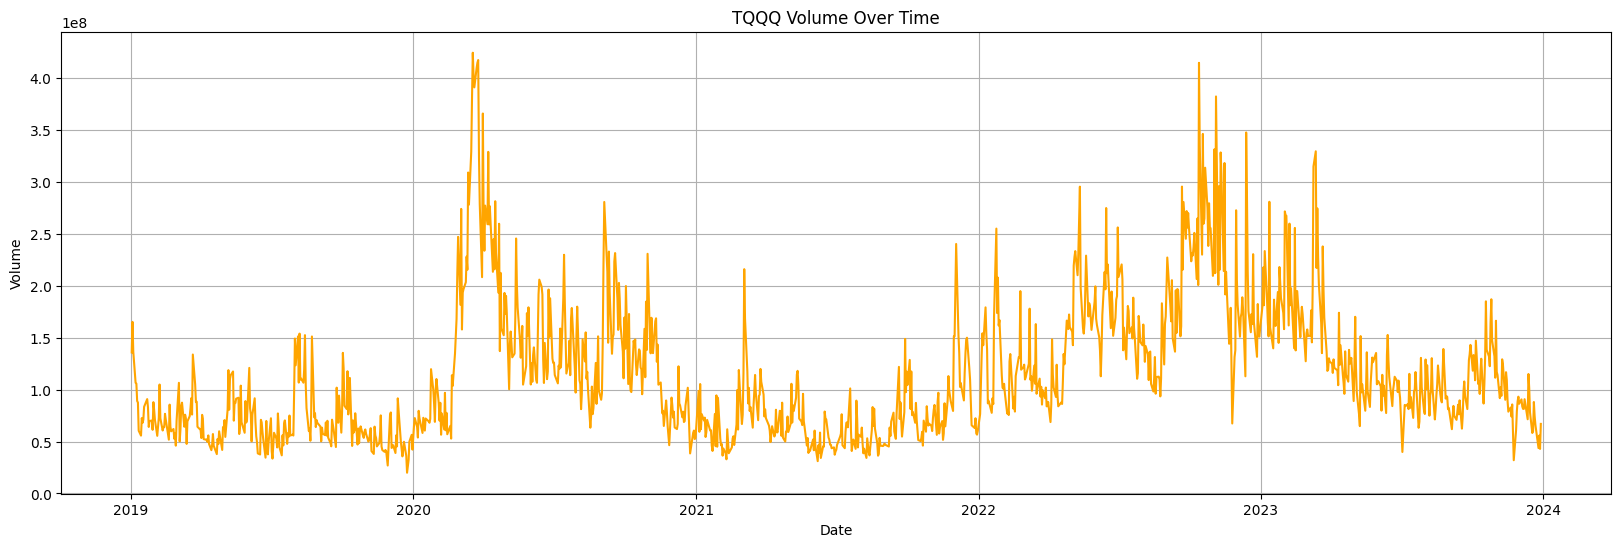

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(tqqq.index, tqqq['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('TQQQ Adjusted Close Price Over Time')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(tqqq.index, tqqq['Volume'], color='orange')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('TQQQ Volume Over Time')
plt.grid(True)
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

가격 급락 이후 대부분 거래량이 급등한다.

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

1. 정상성(Stationarity):
정상성은 시계열 데이터 분석에서 중요한 개념으로, 데이터를 설명하고 예측하기 위한 전제 조건으로 많이 사용됩니다. 정상성을 갖는 시계열 데이터는 시간에 따라 일정한 통계적 성질을 가지며, 이는 다음과 같은 특징을 만족해야 합니다.

평균 불변성: 시계열 데이터의 평균(Expectation)이 시간에 따라 변하지 않고 일정해야 합니다.

𝐸
[
𝑋
𝑡
]
=
𝜇
(for all
𝑡
)
E[X
t
​
 ]=μ(for all t)

분산 불변성: 분산(Variance)이 시간에 따라 일정해야 합니다.

𝑉
𝑎
𝑟
(
𝑋
𝑡
)
=
𝜎
2
(for all
𝑡
)
Var(X
t
​
 )=σ
2
 (for all t)

자기공분산 불변성: 시계열의 자기공분산(Autocovariance)이 두 시점의 시간 차이(lag)에만 의존하며, 시간 자체에는 의존하지 않아야 합니다.

𝐶
𝑜
𝑣
(
𝑋
𝑡
,
𝑋
𝑡
+
ℎ
)
=
𝛾
(
ℎ
)
(for all
𝑡
 and lag
ℎ
)
Cov(X
t
​
 ,X
t+h
​
 )=γ(h)(for all t and lag h)

정상성의 개념은 크게 **약한 정상성(weak stationarity)**과 **강한 정상성(strong stationarity)**으로 나눌 수 있습니다. 약한 정상성은 위 세 가지 조건을 만족하는 반면, 강한 정상성은 데이터의 분포 자체가 시간에 따라 변하지 않는 것을 의미합니다. 일반적으로 시계열 분석에서는 약한 정상성을 가정하는 경우가 많습니다.

2. 정상성을 검증해야 하는 이유

정상성은 ARIMA(자기회귀이동평균 통합) 모델과 같은 시계열 모델을 적용할 때 중요한 가정입니다. 정상성이 확보되지 않은 시계열 데이터는 다음과 같은 문제를 일으킬 수 있습니다.

- 모델 성능 저하: 비정상적인 시계열 데이터는 통계적 모델이 데이터를 정확하게 설명하고 예측하는 데 어려움을 겪게 합니다.
- 통계적 검정 오류: 비정상적인 데이터는 검정 통계량의 분포를 왜곡시켜 유의 수준을 잘못 해석하게 할 수 있습니다.
- 정확한 예측 불가: 평균, 분산, 자기공분산이 시간에 따라 변하는 경우, 장기적 예측이 어려워집니다.

따라서 시계열 분석을 수행하기 전에 정상성을 확인하고 비정상성을 해결해야 모델의 성능과 정확도를 높일 수 있습니다.

3. 비정상성을 해결하는 방법

비정상적인 시계열 데이터는 여러 가지 방법을 통해 정상성으로 변환할 수 있습니다. 일반적인 비정상성을 해결하는 방법은 다음과 같습니다.

- 차분(Differencing)

차분은 시계열 데이터의 시차(lag) 차이를 구하여 비정상성을 줄이는 방법입니다. 1차 차분, 2차 차분 등을 수행하여 데이터의 평균이 일정해지도록 만듭니다. 주로 추세(Trend)나 계절성(Seasonality)을 제거하는 데 효과적입니다.

예:
𝑌
𝑡
=
𝑋
𝑡
−
𝑋
𝑡
−
1
(1차 차분)

Y
t
​
 =X
t
​
 −X
t−1
​
 (1차 차분)

- 로그 변환(Log Transformation)

데이터의 분산이 시간에 따라 증가하거나 감소할 때 사용됩니다. 로그 변환을 하면 데이터의 스케일을 축소하여 분산의 변화를 줄일 수 있습니다.

예:
𝑌
𝑡
=
log
⁡
(
𝑋
𝑡
)
Y
t
​
 =log(X
t
​
 )

- 제곱근 변환(Square Root Transformation)

로그 변환과 유사하게 데이터의 분산을 줄이는 방법입니다. 로그 변환보다 덜 급격하게 변환되므로 데이터의 특성에 맞춰 사용할 수 있습니다.

예:
𝑌
𝑡
=
𝑋
𝑡
Y
t
​
 =
X
t
​

​

- 이동 평균(Moving Average)

데이터의 평균을 계산하여 비정상성을 줄이는 방법입니다. 주로 단기적 노이즈를 제거하고, 데이터의 장기적인 패턴을 파악하는 데 도움을 줍니다.

- 계절성 차분(Seasonal Differencing)

계절성이 있는 비정상 데이터의 경우, 계절 차분을 통해 비정상성을 해결할 수 있습니다. 계절 차분은 동일한 계절 간의 차이를 구하여 계절성을 제거하는 방법입니다.

예:
𝑌
𝑡
=
𝑋
𝑡
−
𝑋
𝑡
−
𝑠
(계절 주기
𝑠
)
Y
t
​
 =X
t
​
 −X
t−s
​
 (계절 주기 s)

- 트렌드 제거(Trend Removal)

데이터의 트렌드를 제거하여 평균을 일정하게 만듭니다. 추세선(Linear Trend) 또는 다항식(Polynomial)을 통해 데이터의 추세를 제거할 수 있습니다.

4. 정상성을 확인하는 방법

정상성을 확인하기 위한 방법으로는 주로 다음의 통계적 검정을 사용합니다.

- ADF 검정(Augmented Dickey-Fuller Test)

시계열 데이터가 단위근(Unit Root)을 갖는지 확인하는 방법입니다. 귀무 가설(H0)은 "단위근이 존재한다(비정상적이다)"이며, 대립 가설(H1)은 "단위근이 존재하지 않는다(정상적이다)"입니다.

- KPSS 검정(Kwiatkowski-Phillips-Schmidt-Shin Test)

ADF와 반대로, 귀무 가설(H0)이 "정상성을 가진다"입니다. KPSS 검정을 통해 ADF 검정의 결과를 보완할 수 있습니다.

- 평균 및 분산의 시간 변화 확인

데이터의 평균과 분산이 시간에 따라 일정한지 확인하여 육안으로도 정상성을 평가할 수 있습니다.

- ACF 및 PACF 그래프 분석

자기상관함수(ACF)와 부분자기상관함수(PACF) 그래프를 통해 데이터의 패턴을 분석하여 정상성을 평가할 수 있습니다.

정상성은 시계열 모델링의 핵심 전제 조건 중 하나이므로, 데이터 분석 전 반드시 확인하고 필요시 적절한 변환을 적용해야 합니다.

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [ ]:
def adf_test(y):
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

In [ ]:
adf_test(tqqq['Adj Close'])

Results of Augmented Dickey-Fuller test:
test statistic            -1.626130
p-value                    0.469517
# of lags                 17.000000
# of observations       1240.000000
Critical Value (1%)       -3.435635
Critical Value (5%)       -2.863874
Critical Value (10%)      -2.568012
dtype: float64


2.3 ADF Test 결과를 해석하세요.

p-value가 0.05보다 크므로 단위근이 존재한다. 정상성을 띄지 않는다

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.


ACF(자기상관함수)는 시계열 데이터의 모든 시차(lag) 간 누적된 상관관계를 보여줍니다. 특정 시차
ℎ
에서의 ACF 값은 시점
𝑡
와
𝑡
−
ℎ
 사이의 상관관계를 나타내며, 전체적인 추세나 계절성을 파악하는 데 유용합니다. 반면, PACF(부분자기상관함수)는 특정 시차에서의 직접적인 상관관계를 나타내며, 다른 시차의 영향을 배제한 순수한 상관성을 제공합니다. PACF는 AR 모델의 차수 설정에 도움을 주며, 특정 시차 이후 값이 급격히 0에 수렴하면 해당 시차까지만 고려한 모델 설정이 가능합니다.

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

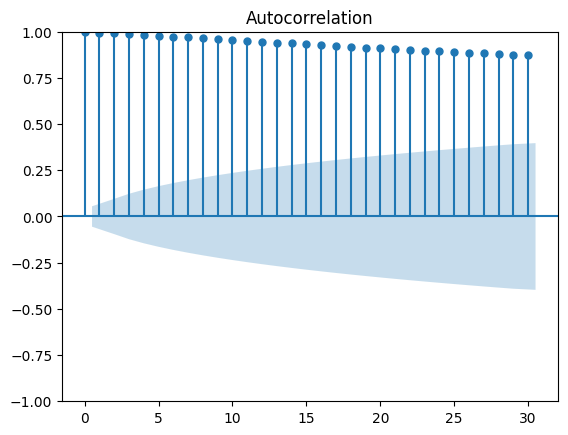

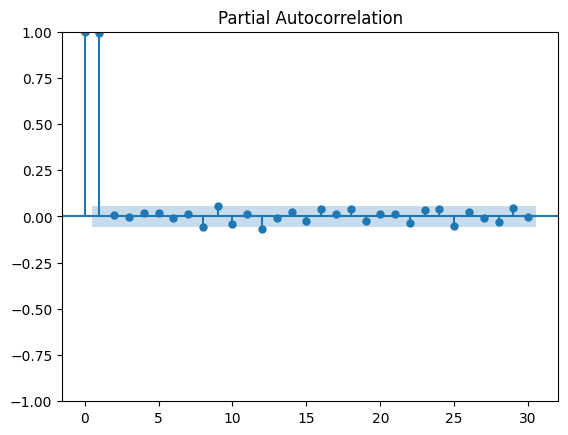

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(tqqq['Adj Close'], lags=30)
plot_pacf(tqqq['Adj Close'], lags=30)
plt.show()

2.6 결과를 해석하세요.

ACF 그래프는 0 시차에서 1로 시작해서 점진적으로 감소한다. 이는 데이터에 추세가 존재할 수 있음을 보인다. 시차가 커짐에도 ACF 값이 0에 가깝게 크게 줄어들지 않는다면 비정상성을 띠고 있음을 의미한다.


PACF 그래프는 0시차에서 1로 시작하고, 2차 시차 이후 부터는 0에 가까운 값을 보이며, 이는 AR 모델을 따를 가능성이 높다는 의미이다. 즉 1차 자기회귀모델로 설명될 수 있으며 1차 시차 이후에는 상관성이 거의 없음을 보여준다


2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

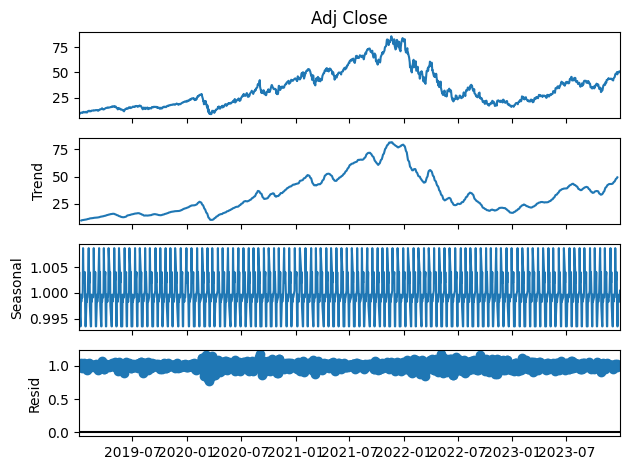

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(tqqq['Adj Close'], model='multiplicated', period=12)
result.plot()
plt.show()

2.8 위 결과를 해석하세요.

계절성 그래프가 매우 작은 진폭으로 주기적인 패턴을 보이고 있다. 주기적인 변동이 존재하지만 영향이 상대적으로 작음을 의미한다. 주기적인 변동이 있지만 진폭이 매우작아 주가 변동에 큰영향이 없음을 알 수 있다.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

연이은 관측값의 차이를 계산하는 것으로 시계열의 수준에서 나타나는 변화를 제거하여 시계열의 평균 변화를 일정하게 만들고, 결과적으로 추세나 계절성이 제거(또는 감소)됩니다.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [ ]:
tqqq['Adj Close_diff'] = tqqq['Adj Close'].diff()
adf_test(tqqq['Adj Close_diff'][1:])

Results of Augmented Dickey-Fuller test:
test statistic         -7.344847e+00
p-value                 1.042106e-10
# of lags               2.300000e+01
# of observations       1.233000e+03
Critical Value (1%)    -3.435665e+00
Critical Value (5%)    -2.863887e+00
Critical Value (10%)   -2.568020e+00
dtype: float64


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

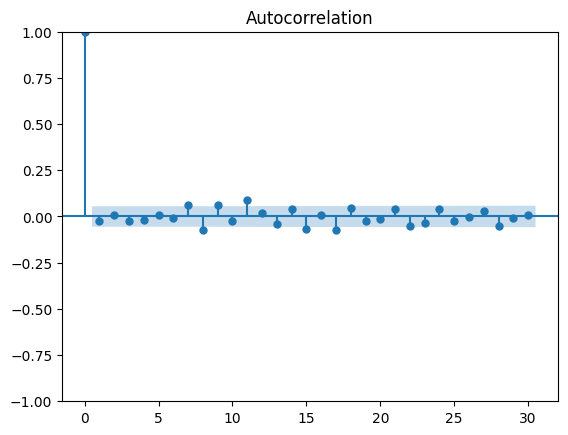

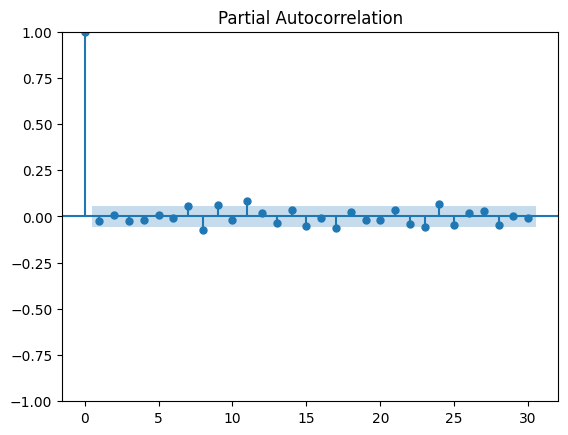

In [ ]:
plot_acf(tqqq['Adj Close_diff'][1:], lags=30)
plot_pacf(tqqq['Adj Close_diff'][1:], lags=30)
plt.show()

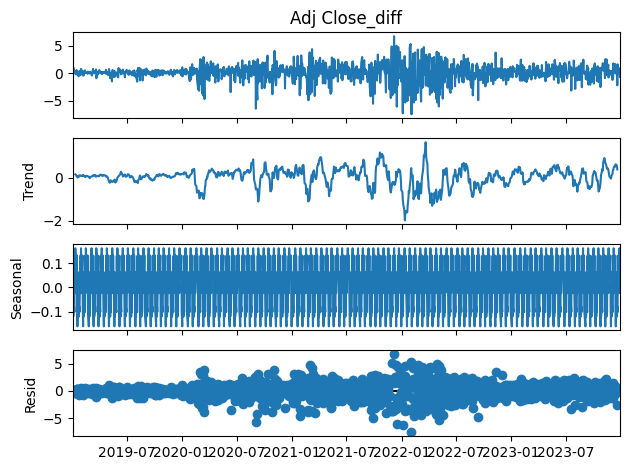

In [ ]:
result_diff = seasonal_decompose(tqqq['Adj Close_diff'][1:], model='additive', period=12)
result_diff.plot()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
data['Adj Close_diff']

Date
2019-01-02         NaN
2019-01-03   -3.760181
2019-01-04    1.450996
2019-01-07   -0.078880
2019-01-08    0.674103
                ...   
2023-12-22   -1.075882
2023-12-26   -0.547943
2023-12-27    0.099625
2023-12-28    0.428375
2023-12-29   -1.046036
Name: Adj Close_diff, Length: 1258, dtype: float64

In [ ]:
model = ARIMA(data['Adj Close_diff'], order=(3, 0, 0))  #위에서 차분을 미리 했으므로 차분 값은 0으로 설정
model_fit = model.fit()


model_fit.summary()

C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Adj Close_diff   No. Observations:                 1258
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2858.574
Date:                Tue, 27 Aug 2024   AIC                           5727.148
Time:                        23:58:51   BIC                           5752.834
Sample:                             0   HQIC                          5736.801
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1227      0.062      1.969      0.049       0.001       0.245
ar.L1         -0.0434      0.022     -1.986      0.047      -0.086      -0.001
ar.L2         -0.0264      0.023     -1.162      0.245      -0.071       0.018
ar.L3         -0.0158      0.024     -0.658      0.511      -0.063       0.031
sigma2         5.5310      0.149     37.232      0.000       5.240       5.822
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               349.98
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


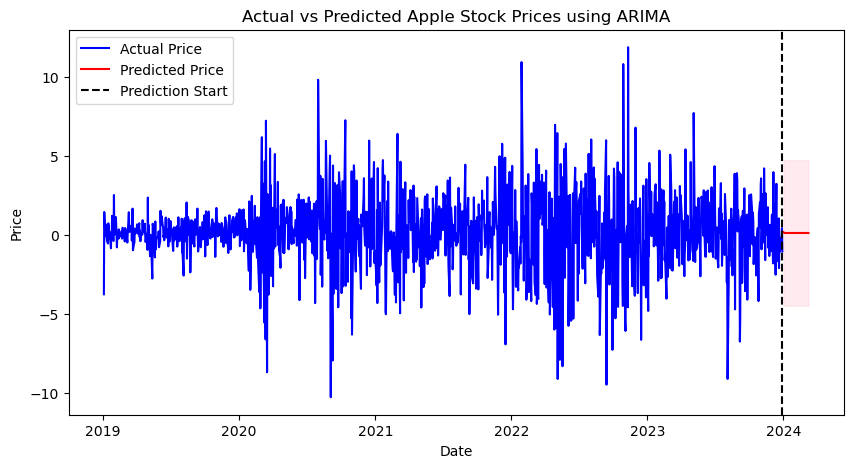

In [ ]:
#예측 수행(50일, 200일해도 달라지지 않았음 ㅠ)
forecast_result = model_fit.get_forecast(steps=50)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

#예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(df.index, data['Adj Close_diff'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=data.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Apple Stock Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
#실제 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-03-01')
actual_last_50 = actual_data_last_50[['Close']]


[*********************100%%**********************]  1 of 1 completed


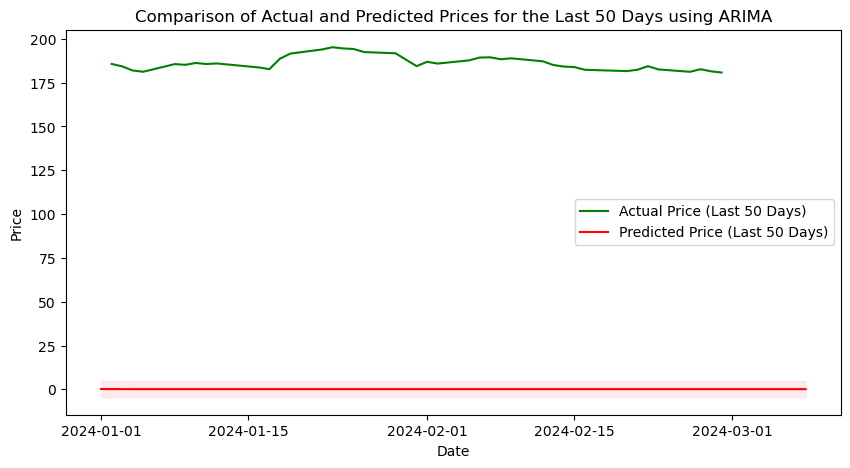

In [ ]:
#실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [ ]:
from prophet import Prophet

In [ ]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = 'AAPL'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%%**********************]  1 of 1 completed


In [ ]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

00:06:19 - cmdstanpy - INFO - Chain [1] start processing
00:06:19 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

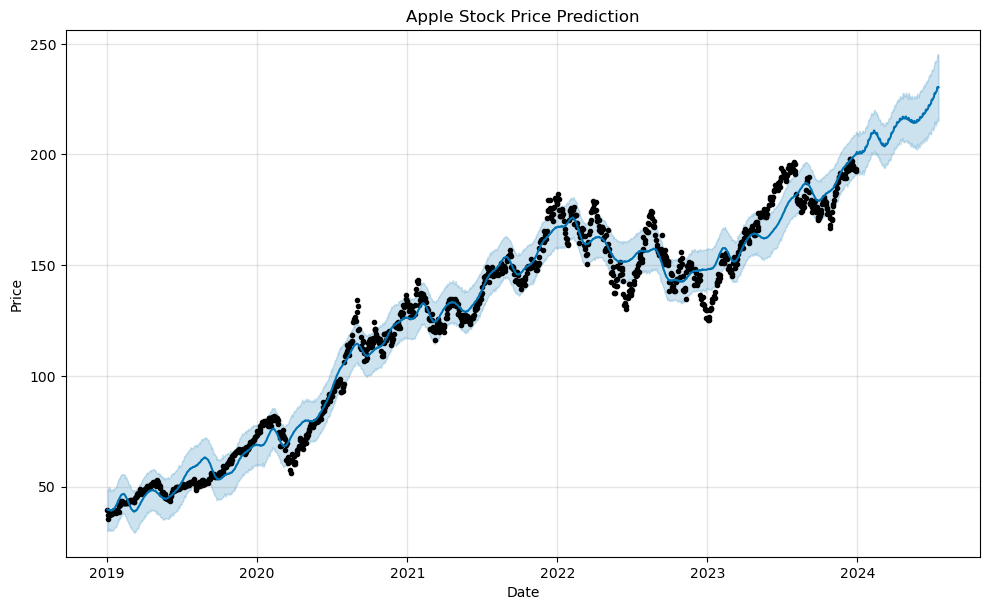

In [ ]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

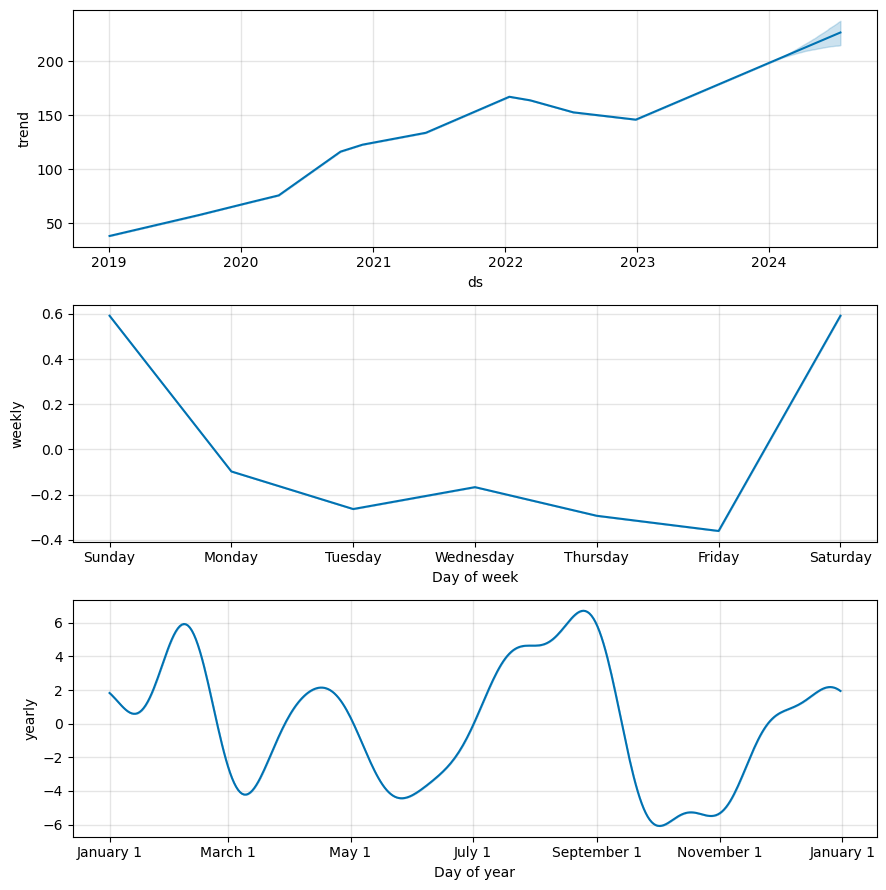

In [ ]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%%**********************]  1 of 1 completed


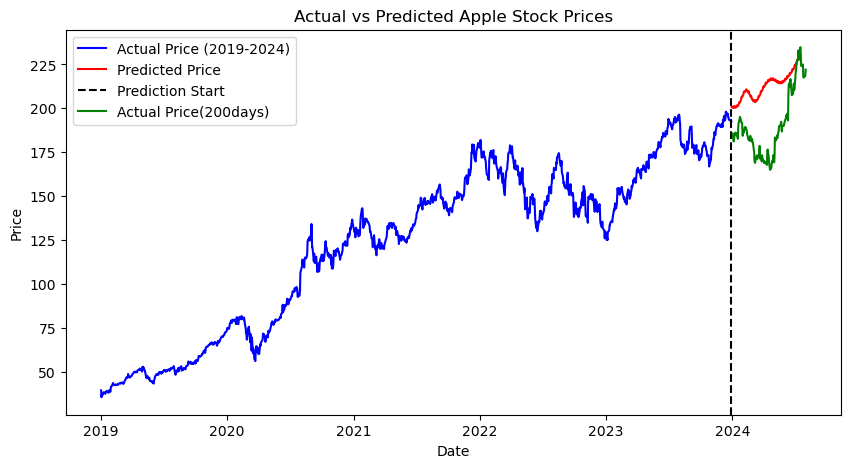

In [ ]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다.

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다.

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.

In [ ]:
#LSTM을 활용하여 진행

tqqq['Adj Close_diff']

,Adj Close_diff
Date,
2019-01-02,NaN
2019-01-03,-0.880112
2019-01-04,1.049365
2019-01-07,0.294985
2019-01-08,0.275639
...,...
2023-12-22,0.197876
2023-12-26,0.910271
2023-12-27,0.267143


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 스케일러 생성 및 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tqqq[['Adj Close_diff']].dropna())

In [ ]:
import numpy as np

# 시퀀스 데이터 구성 함수 정의
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 시퀀스 길이 설정 (예: 10개 시점)
time_step = 10
X, y = create_dataset(scaled_data, time_step)

In [ ]:
# 데이터 형태 변환: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
# 데이터셋 분리 (80%는 학습용, 20%는 테스트용)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# LSTM 모델 구성
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(time_step, 1)))  # 첫 번째 LSTM 레이어
model.add(LSTM(200, return_sequences=False))  # 두 번째 LSTM 레이어
model.add(Dense(1))  # 출력 레이어

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 모델 학습 (epochs: 반복 학습 횟수, batch_size: 배치 크기)
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0727
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0143
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0140
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0134
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0157
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0158
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0141
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0130
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0143
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0150
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0131
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0151
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0159
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0138
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - lo

In [ ]:
# 예측 수행
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 예측 결과를 원래 스케일로 복원
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


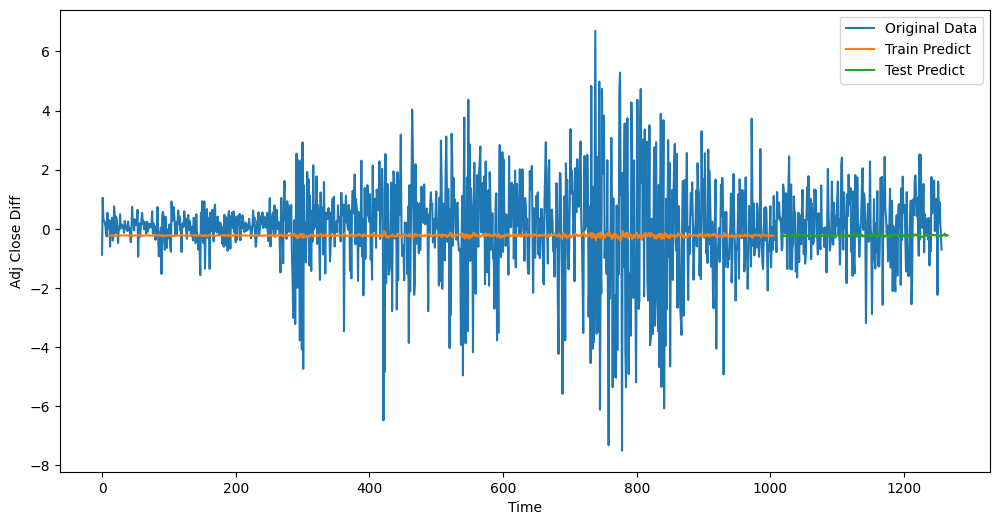

In [ ]:
import matplotlib.pyplot as plt

# 원래 데이터와 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(np.arange(time_step, time_step + len(train_predict)), train_predict, label='Train Predict')
plt.plot(np.arange(len(X_train) + (time_step * 2), len(X_train) + (time_step * 2) + len(test_predict)), test_predict, label='Test Predict')
plt.xlabel('Time')
plt.ylabel('Adj Close Diff')
plt.legend()
plt.show()

잘 예측이 되지 않아서 튜닝 진행

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 준비
data = tqqq[['Adj Close_diff']].dropna()  # 결측치 제거
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values)

# 시계열 데이터 생성 함수 (window size 사용)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)


In [ ]:
# 하이퍼파라미터 설정
window_size = 50  # 윈도우 사이즈 (입력 시퀀스 길이)
batch_size = 16   # 배치 크기
epochs = 100      # 학습 반복 횟수
learning_rate = 0.0001  # 학습률

# 시계열 데이터 생성
X, y = create_sequences(scaled_data, window_size)


In [ ]:
# 학습 데이터와 테스트 데이터 분리
split_ratio = 0.8
split = int(split_ratio * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM 입력 형식으로 데이터 reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=False))  # 한 층 더 추가
model.add(Dropout(0.3))
model.add(Dense(units=1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 조기 종료 (Early Stopping) 설정
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 모델 학습
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 0.0632 - val_loss: 0.0083
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0099 - val_loss: 0.0079
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.0093 - val_loss: 0.0078
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0090 - val_loss: 0.0078
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - loss: 0.0086 - val_loss: 0.0078
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.0090 - val_loss: 0.0078
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 87

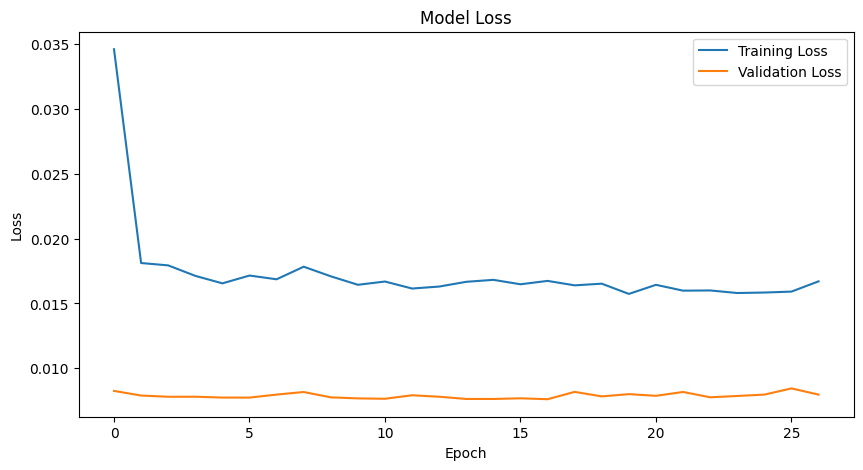

In [ ]:
# 학습 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 테스트 데이터 예측
y_pred = model.predict(X_test)

# 예측값 역스케일링
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


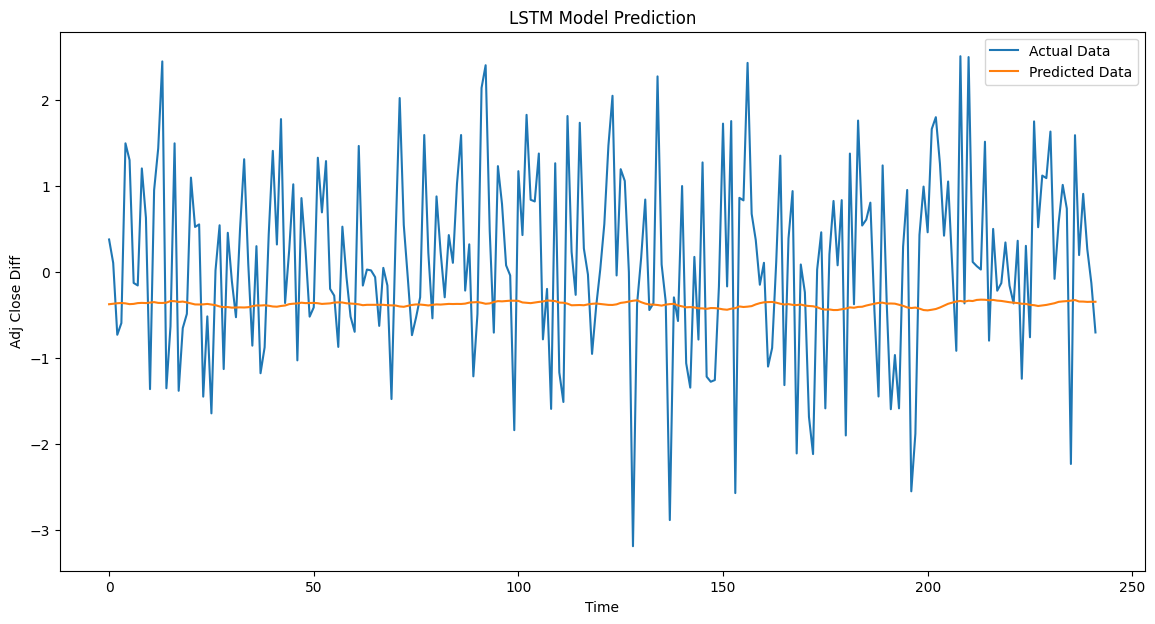

In [ ]:
# 예측 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Data')
plt.plot(y_pred_inv, label='Predicted Data')
plt.title('LSTM Model Prediction')
plt.xlabel('Time')
plt.ylabel('Adj Close Diff')
plt.legend()
plt.show()


## 잘 안되는 것 같아요...
구글링을 해보았습니다.

시가를 예측했고, 이전에는 수정종가만 활용했다면 이 예시에는 다른 가격을 모두 고려했슴.

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


No weights found, training model from scratch
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.3161 - val_loss: 0.0154
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0200 - val_loss: 0.0064
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0138 - val_loss: 0.0045
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0117 - val_loss: 0.0074
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0078 - val_loss: 0.0055
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0079 - val_loss: 0.0034
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0073 - val_loss: 0.0035
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 9/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0062 - val_loss: 0.0033
Epoch 10/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0061 - val_loss: 0.0039
Epoch 11/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 12/30
32/32

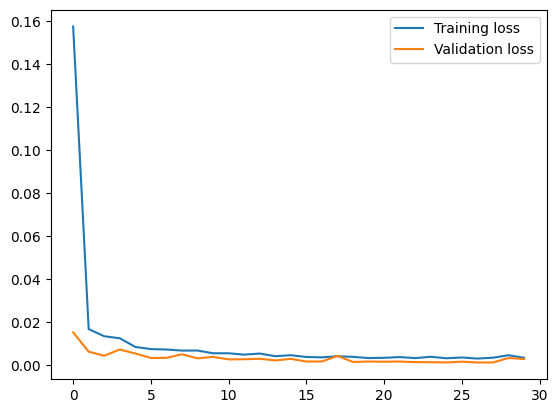

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


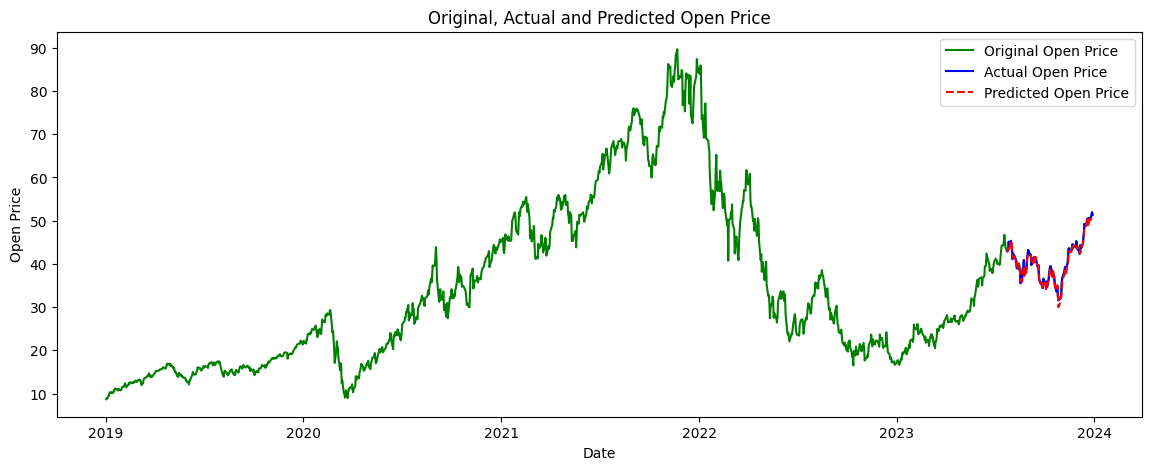

In [ ]:
# 필요한 라이브러리 설치
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# matplotlib inline 설정
%matplotlib inline

# 데이터 로드 및 전처리
ticker = 'tqqq'
stock_data = yf.download(ticker, start='2019-01-01', end='2024-01-01')
stock_data = stock_data.reset_index()

stock_data.drop(['Adj Close'], axis=1, inplace=True)

# 기존 Open Price 저장
original_open = stock_data['Open'].values
dates = pd.to_datetime(stock_data['Date'])

cols = list(stock_data)[1:6]
stock_data = stock_data[cols].astype(float)

# 데이터 정규화
scaler = StandardScaler()
scaler = scaler.fit(stock_data)
stock_data_scaled = scaler.transform(stock_data)

# 훈련 및 테스트 데이터 분리
n_train = int(0.9 * stock_data_scaled.shape[0])
train_data_scaled = stock_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = stock_data_scaled[n_train:]
test_dates = dates[n_train:]

pred_days = 1
seq_len = 14
input_dim = 5

trainX, trainY, testX, testY = [], [], [], []

for i in range(seq_len, n_train - pred_days + 1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled) - pred_days + 1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(trainY.shape[1]))

# 모델 컴파일
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# 가중치 저장 경로 설정
save_path = '/content/lstm_weights.weights.h5'
try:
    model.load_weights(save_path)
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    history = model.fit(trainX, trainY, epochs=30, batch_size=32, validation_split=0.1, verbose=1)
    model.save_weights(save_path)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

# 예측 수행
prediction = model.predict(testX)
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)
mean_values_pred[:, 0] = np.squeeze(prediction)
y_pred = scaler.inverse_transform(mean_values_pred)[:, 0]

mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)
mean_values_testY[:, 0] = np.squeeze(testY)
testY_original = scaler.inverse_transform(mean_values_testY)[:, 0]

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(dates, original_open, color='green', label='Original Open Price')
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Open Price')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Open Price')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Original, Actual and Predicted Open Price')
plt.legend()
plt.show()


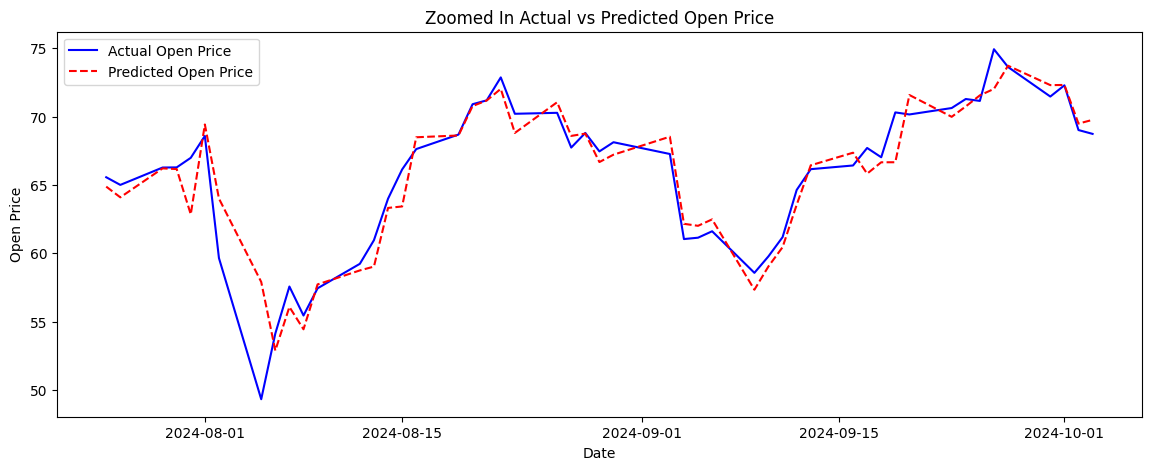

In [ ]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Open Price')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Open Price')

plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Zoomed In Actual vs Predicted Open Price')
plt.legend()
plt.show()

#ARIMAX

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# 데이터 로드 및 전처리
ticker = 'tqqq'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')
data['Adj Close_diff'] = data['Adj Close'].diff().dropna()  # 차분
data = data.dropna()  # 결측값 제거


[*********************100%***********************]  1 of 1 completed


In [ ]:
# 외생 변수로 사용할 거래량 데이터를 추가
exog = data[['Volume']]


In [ ]:
# ARIMAX 모델 정의 및 학습
model = ARIMA(data['Adj Close_diff'], exog=exog, order=(3, 0, 0))  # 차분이 이미 되었으므로 d=0
model_fit = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Adj Close_diff   No. Observations:                 1257
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2322.112
Date:                Mon, 07 Oct 2024   AIC                           4656.224
Time:                        04:07:55   BIC                           4687.043
Sample:                             0   HQIC                          4667.806
                               - 1257                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3582   1.68e-18   2.14e+17      0.000       0.358       0.358
Volume     -2.802e-09   2.77e-10    -10.128      0.000   -3.34e-09   -2.26e-09
ar.L1         -0.0247   1.65e-19   -1.5e+17      0.000      -0.025      -0.025
ar.L2          0.0042   6.28e-19   6.65e+15      0.000       0.004       0.004
ar.L3         -0.0234   4.11e-19  -5.69e+16      0.000      -0.023      -0.023
sigma2         2.3598   3.07e-19    7.7e+18      0.000       2.360       2.360
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               496.01
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


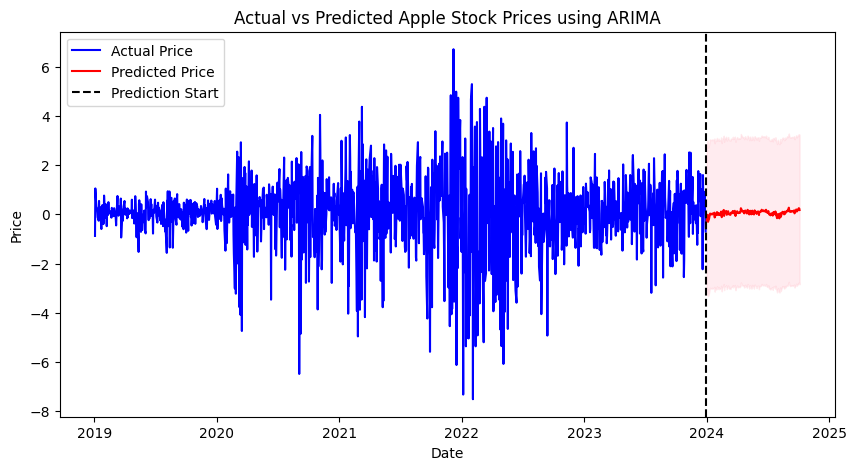

In [ ]:
# 예측 수행 (향후 200일 예측)
forecast_result = model_fit.get_forecast(steps=200, exog=exog[-200:])  # 향후 200일 예측, 마지막 200일의 exog 데이터 사용
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()


#예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Adj Close_diff'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=201, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=data.index[-1], periods=201, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=data.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Apple Stock Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
#실제 데이터 가져오기
actual_data_last_200 = yf.download(ticker, start='2024-01-01', end='2024-10-01')
actual_last_200 = actual_data_last_200[['Close']]


[*********************100%***********************]  1 of 1 completed


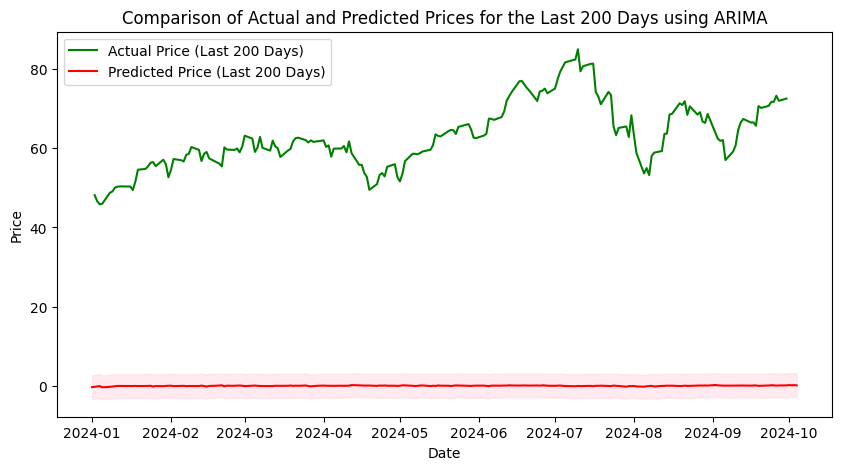

In [ ]:
#실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_200.index, actual_last_200['Close'], label='Actual Price (Last 200 Days)', color='green')
plt.plot(pd.date_range(start=data.index[-1], periods=201, freq='B')[1:], forecast, label='Predicted Price (Last 200 Days)', color='red')
plt.fill_between(pd.date_range(start=data.index[-1], periods=201, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 200 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

arimax도 잘 안됨